In [5]:
import os
import h5py as h5
import numpy as np
import pandas as pd
#import mat_img_reader as mir
from sklearn import tree,naive_bayes
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#parse each mat structure into a python patient object
class Patient(object):
    PID = ""
    image=""
    label=""
    tumorBorder=""
    tumorMask=""
    
    def __init__(self, PID, image, label,tumorBorder,tumorMask):
        self.PID = PID
        self.image = image
        self.label = label
        self.tumorBorder=tumorBorder
        self.tumorMask=tumorMask

In [7]:
f=[]
file_path="/content/drive/My Drive/Colab Notebooks/Brain/New folder/"

for i in tqdm(range(100)):
     f.append(h5.File(os.path.join(file_path,str(i+1)+".mat"),'a'))

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [8]:
p=[]
for i in  tqdm(range(100)):
    p.append(Patient('','','','',''))
    p[i].image=np.array(f[i]['/cjdata/image'])
    p[i].PID=np.array(f[i]['/cjdata/PID'])
    p[i].label=f[i]['/cjdata/label'][0][0]
    p[i].tumorBorder=f[i]['/cjdata/tumorBorder'][0]
    p[i].tumorMask=list(f[i]['/cjdata/tumorMask'])[0]

100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


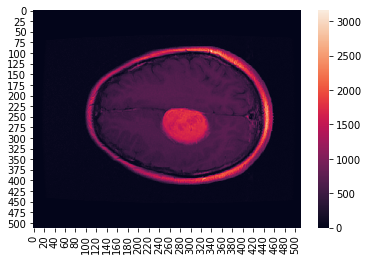

In [9]:
sns.heatmap(p[10].image)

In [10]:
#sns.heatmap(p[200].tumorMask)
print(p[10].label)

1.0


In [11]:
columns =['PID', 'image', 'label', 'tumorBorder', 'tumorMask']    

d={'PID':[], 'image':[], 'label':[], 'tumorBorder':[], 'tumorMask':[]}

for i in tqdm(range(100)):
    d['PID'].append(p[i].PID)
    d['image'].append(p[i].image)
    d['label'].append(p[i].label)
    d['tumorBorder'].append(p[i].tumorBorder)
    d['tumorMask'].append(p[i].tumorMask)

100%|██████████| 100/100 [00:00<00:00, 96620.69it/s]


In [0]:
#making dataframe
Patient_data=pd.DataFrame(list(d.values()),columns)

Patient_data=Patient_data.transpose()

In [13]:
#preprocessing image data for training x_train

#files with corrupted images from (256,256) to (512,512)
count=0
for i in tqdm(range(100)): 
     if np.array(p[i].image).shape[0]!= 512 or np.array(p[i].image).shape[1]!=512:
         #print("worst")
         p[i].image=np.concatenate((np.zeros((256,256)),np.zeros((256,256))),axis=0)
         p[i].image=np.concatenate((p[i].image,np.zeros((512,256))),axis=1)
         print(i)
         count+=1

100%|██████████| 100/100 [00:00<00:00, 3305.00it/s]


In [14]:
""" training images only having (512,512)"""
image_train=[]
label_train=[]
         

for i in tqdm(range(100)):
    image_train.append(p[i].image)
    label_train.append(p[i].label)
    
image_train=np.array(image_train)
label_train=np.array(label_train)

100%|██████████| 100/100 [00:00<00:00, 97067.90it/s]


In [15]:
print('\nlabels:', label_train.shape)
print('images:', image_train.shape)


labels: (100,)
images: (100, 512, 512)


In [0]:
np.save("/content/drive/My Drive/Colab Notebooks/Brain/labels2.npy", label_train)
np.save("/content/drive/My Drive/Colab Notebooks/Brain/images2.npy", image_train)

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

In [0]:
labels = np.load("/content/drive/My Drive/Colab Notebooks/Brain/labels2.npy")
images = np.load("/content/drive/My Drive/Colab Notebooks/Brain/images2.npy")

In [20]:
print(labels.shape)
print(images.shape)

(100,)
(100, 512, 512)


In [23]:
labels.shape[1]

IndexError: ignored

In [24]:
labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

ValueError: ignored

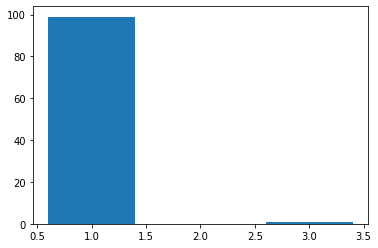

In [25]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])



In [24]:
print(classes)

[1. 2. 3.]


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [0]:
seed=1234
np.random.seed(seed)

In [30]:
images[5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

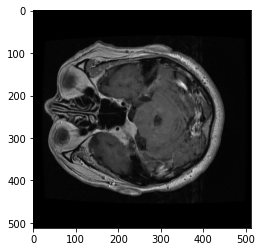

In [31]:
plt.imshow(images[5],cmap=plt.get_cmap('gray'))

In [33]:
images.shape[0]

100

In [0]:
images=images.reshape(images.shape[0],1,512,512).astype("float32")

In [0]:
images=images/255

In [0]:
labels=np_utils.to_categorical(labels)

In [0]:
num_classes=labels.shape[1]

In [30]:
num_classes

4

In [31]:
labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [32]:
labels[19]

array([0., 1., 0., 0.], dtype=float32)

In [0]:
def model_arc():
  model=Sequential()
  model.add(Conv)